# SET UP

## Imports
Libraries used: pandas, numpy, matplotlib, seaborn, sklearn, xgboost, joblib

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import learning_curve, cross_val_score, train_test_split
from sklearn import tree

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

import joblib

## Functions
Some functions that we use in classes that can help in some analyses when studying some databases

### identify_low_variance_features

In [2]:
def identify_low_variance_features(df, std_threshold):
    """
    This definition can be used to identify features with low varaince
    
    @param df pandas DataFrame
    @param std_threshold int 
    
    @return a list of features that have low variance
    """
    
    std_df = pd.DataFrame(df.std()).rename(columns = {0: 'standard_deviation'})

    low_var_features = list(std_df[std_df['standard_deviation'] < std_threshold].index)

    print("number of low variance features:", len(low_var_features))
    print("low variance features:", low_var_features)
    
    return low_var_features

### identify_highly_correlated_features

In [3]:
def identify_highly_correlated_features(df, correlation_threshold):
    """
    This definition can be used to identify highly correlated features
    
    @param df pandas DataFrame
    @param correlation_threshold int 
    
    @return a DataFrame with highly correlated features 
    """
    
    corr_matrix = df.corr(numeric_only = True).abs() # calculate the correlation matrix with 
    high_corr_var = np.where(corr_matrix >= correlation_threshold) # identify variables that have correlations above defined threshold
    high_corr_var = [(corr_matrix.index[x], corr_matrix.columns[y], round(corr_matrix.iloc[x, y], 2))
                         for x, y in zip(*high_corr_var) if x != y and x < y] # identify pairs of highly correlated variables
    
    high_corr_var_df = pd.DataFrame(high_corr_var).rename(columns = {0: 'corr_feature',
                                                                     1: 'drop_feature',
                                                                     2: 'correlation_values'})

    if high_corr_var_df.empty:
        high_corr_var_df
    else:
        high_corr_var_df = high_corr_var_df.sort_values(by = 'correlation_values', ascending = False)

    return high_corr_var_df

### identify_missing_data

In [4]:
def identify_missing_data(df):
    """
    This function is used to identify missing data
    
    @param df pandas DataFrame
    
    @return a DataFrame with the percentage of missing data for every feature and the data types
    """
    
    percent_missing = df.isnull().mean()
    
    missing_value_df = pd.DataFrame(percent_missing).reset_index() # convert to DataFrame
    missing_value_df = missing_value_df.rename(columns = {"index" : "feature",
                                                                0 : "percent_missing"}) # rename columns

    missing_value_df = missing_value_df.sort_values(by = ['percent_missing'], ascending = False) # sort the values
    
    data_types_df = pd.DataFrame(df.dtypes).reset_index().rename(columns = {"index" : "feature",
                                                                0 : "data_type"}) # rename columns
    
    missing_value_df = missing_value_df.merge(data_types_df, on = "feature") # join the dataframe with datatype
    
    missing_value_df.percent_missing = round(missing_value_df.percent_missing*100, 2) # format the percent_missing
    
    return missing_value_df[missing_value_df.percent_missing > 0]

### one_hot

In [5]:
def one_hot(df, categorical_cols):
    """
    @param df pandas DataFrame
    @param cols a list of columns to encode 
    @return a DataFrame with one-hot encoding
    """
    
    for c in categorical_cols:
        dummies = pd.get_dummies(df[c], prefix=c)
        df = pd.concat([df, dummies], axis=1)
        df.drop(c, axis = 1, inplace = True)
    
    return df

### feature_importance_plot

In [6]:
def feature_importance_plot(model, X_train, n):
    """Plots feature importance - this only works for Random Forest and XGBoost Models

    @param model - the trained model
    @param X_train dataframe - the training dataset
    @param n int - the number of features we are interested in plotting
    
    @return a plot with the Top n features
    """
    
    plt.figure(figsize=(8, 5)) # set figure size
    feat_importances = pd.Series(model.feature_importances_,
                                 index = X_train.columns)
    feat_importances.nlargest(n).plot(kind = 'bar')
    plt.title(f"Top {n} Features")
    plt.show()

### learning_curve_plot

In [7]:
def learning_curve_plot(model, X_train_scaled, y_train_scaled, scoring, plusTitle):
    """Plots learning curves for model validation
    
    @param models - list of models we are interested in evaluating
    @param X_train_scaled - the training features
    @param y_train_scaled - the target
    
    @returns a plot of the learning curve
    """
    
    fig, ax = plt.subplots(figsize=(5, 5)) # Use subplots to link fig and ax
    train_sizes, train_scores, test_scores = learning_curve(
        model,
        X_train_scaled,
        y_train_scaled,
        # Number of folds in cross-validation
        cv = 5,
        # Evaluation metric
        scoring = scoring,
        # Use all computer cores
        n_jobs = -1,
        shuffle = True,
        # 5 different sizes of the training set
        train_sizes = np.linspace(0.01, 1.0, 5))

    # Create means and standard deviations of training set scores
    train_mean = np.mean(train_scores, axis = 1)
    train_std = np.std(train_scores, axis = 1)

    # Create means and standard deviations of test set scores
    test_mean = np.mean(test_scores, axis = 1)
    test_std = np.std(test_scores, axis = 1)

    ax.scatter(train_sizes, train_mean, color='k', s=8)
    ax.scatter(train_sizes, test_mean, color='k', s=8)
    
    # Draw lines
    ax.plot(train_sizes, train_mean, '--', color = "#111111", label = "Training score")
    ax.plot(train_sizes, test_mean, color = "#111111", label = "Cross-validation score")

    # Draw bands
    # ax.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color = "#DDDDDD")
    # ax.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color = "#DDDDDD")

    # Create plot
    ax.set_title(f"Learning Curves {plusTitle}")
    ax.set_xlabel("Training Set Size"), ax.set_ylabel("Error"), ax.legend(loc = "best")    

    return fig

# DF

## Information
Information about df columns

- **age**: age in years
- **sex**: sex
    - 1: male
    - 0: female
- **cp**: chest pain type
    - 1: typical angina
    - 2: atypical angina
    - 3: non-anginal pain
    - 4: asymptomatic
- **trestbps**: resting blood pressure (in mm Hg on admission to the hospital)
- **chol**: serum cholesterol in mg/dl
- **fbs**: (fasting blood sugar > 120 mg/dl)
    - 1: true
    - 0: false
- **restecg**: resting electrocardiographic results
    - 0: normal
    - 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
    - 2: showing probable or definite left ventricular hypertrophy by Estes’ criteria
- **thalach**: maximum heart rate achieved
- **exang**: exercise-induced angina
    - 1 = yes
    - 0 = no
- **oldpeak**: ST depression induced by exercise relative to rest
- **target**: does the patient have heart disease
    - 1: heart disease
    - 0: not heart disease

## Visualization
First visualization of the df

In [8]:
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 6)

df = pd.read_csv('../data/heart_attack_data.csv')
df = df.rename(columns={'num       ': 'target'})
df = df.replace('?', np.nan)

df

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,28,1,2,130,132,0,2,185,0,0.0,NaN,NaN,NaN,0
1,29,1,2,120,243,0,0,160,0,0.0,NaN,NaN,NaN,0
2,29,1,2,140,NaN,0,0,170,0,0.0,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
291,56,1,4,155,342,1,0,150,1,3.0,2,NaN,NaN,1
292,58,0,2,180,393,0,0,110,1,1.0,2,NaN,7,1
293,65,1,4,130,275,0,1,115,1,1.0,2,NaN,NaN,1


## Preliminary study
Understand the data and have a general overview

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294 entries, 0 to 293
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       294 non-null    int64  
 1   sex       294 non-null    int64  
 2   cp        294 non-null    int64  
 3   trestbps  293 non-null    object 
 4   chol      271 non-null    object 
 5   fbs       286 non-null    object 
 6   restecg   293 non-null    object 
 7   thalach   293 non-null    object 
 8   exang     293 non-null    object 
 9   oldpeak   294 non-null    float64
 10  slope     104 non-null    object 
 11  ca        3 non-null      object 
 12  thal      28 non-null     object 
 13  target    294 non-null    int64  
dtypes: float64(1), int64(4), object(9)
memory usage: 32.3+ KB


In [10]:
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 10)

df.describe()

,age,sex,cp,oldpeak,target
count,294.000000,294.000000,294.000000,294.000000,294.000000
mean,47.826531,0.724490,2.982993,0.586054,0.360544
std,7.811812,0.447533,0.965117,0.908648,0.480977
min,28.000000,0.000000,1.000000,0.000000,0.000000
25%,42.000000,0.000000,2.000000,0.000000,0.000000
50%,49.000000,1.000000,3.000000,0.000000,0.000000
75%,54.000000,1.000000,4.000000,1.000000,1.000000
max,66.000000,1.000000,4.000000,5.000000,1.000000


In [11]:
missing_value_df = identify_missing_data(df)
missing_value_df

,feature,percent_missing,data_type
0,ca,98.98,object
1,thal,90.48,object
2,slope,64.63,object
3,chol,7.82,object
4,fbs,2.72,object
5,trestbps,0.34,object
6,restecg,0.34,object
7,thalach,0.34,object
8,exang,0.34,object


target
0    0.639456
1    0.360544
Name: proportion, dtype: float64



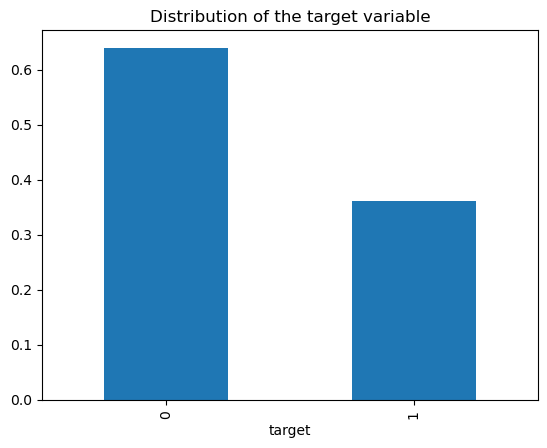

In [12]:
print(df.target.value_counts(dropna = True, normalize = True))
print()

df.target.value_counts(dropna = True, normalize = True).plot(kind = 'bar')

plt.title("Distribution of the target variable")
plt.show()

# DATA CLEANING

## logic

In [13]:
percentage_off_missing_data_to_drop = 70

cols_to_drop = list(missing_value_df[missing_value_df.percent_missing > percentage_off_missing_data_to_drop].feature)
print(cols_to_drop)

df_cleaned = df.drop(cols_to_drop, axis = 1)

['ca', 'thal']


In [14]:
missing_value_df = identify_missing_data(df_cleaned)
missing_value_df

,feature,percent_missing,data_type
0,slope,64.63,object
1,chol,7.82,object
2,fbs,2.72,object
3,trestbps,0.34,object
4,restecg,0.34,object
5,thalach,0.34,object
6,exang,0.34,object


In [15]:
df_cleaned[df_cleaned.duplicated(keep = False)]

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,target
101,49,0,2,110,NaN,0,0,160,0,0.0,NaN,0
102,49,0,2,110,NaN,0,0,160,0,0.0,NaN,0


In [16]:
df_cleaned = df_cleaned[~df_cleaned.duplicated(keep='first')]

## df_cleaned

In [17]:
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 10)

df_cleaned

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,target
0,28,1,2,130,132,0,2,185,0,0.0,NaN,0
1,29,1,2,120,243,0,0,160,0,0.0,NaN,0
2,29,1,2,140,NaN,0,0,170,0,0.0,NaN,0
3,30,0,1,170,237,0,1,170,0,0.0,NaN,0
4,31,0,2,100,219,0,1,150,0,0.0,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...
289,52,1,4,160,331,0,0,94,1,2.5,NaN,1
290,54,0,3,130,294,0,1,100,1,0.0,2,1
291,56,1,4,155,342,1,0,150,1,3.0,2,1
292,58,0,2,180,393,0,0,110,1,1.0,2,1


# FEATURE ENGINEERING

## Handling Missing Data

In [18]:
missing_value_df = identify_missing_data(df_cleaned)
missing_value_df

,feature,percent_missing,data_type
0,slope,64.51,object
1,chol,7.51,object
2,fbs,2.73,object
3,trestbps,0.34,object
4,restecg,0.34,object
5,thalach,0.34,object
6,exang,0.34,object


In [19]:
for column in list(missing_value_df.feature):
    df_cleaned[column] = df_cleaned[column].fillna(0)

In [20]:
missing_value_df = identify_missing_data(df_cleaned)
missing_value_df

,feature,percent_missing,data_type


In [21]:
df_cleaned.info()

for col in df_cleaned.select_dtypes(include='object').columns:
    df_cleaned[col] = pd.to_numeric(df_cleaned[col], errors='raise').astype(int)

df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 293 entries, 0 to 293
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       293 non-null    int64  
 1   sex       293 non-null    int64  
 2   cp        293 non-null    int64  
 3   trestbps  293 non-null    object 
 4   chol      293 non-null    object 
 5   fbs       293 non-null    object 
 6   restecg   293 non-null    object 
 7   thalach   293 non-null    object 
 8   exang     293 non-null    object 
 9   oldpeak   293 non-null    float64
 10  slope     293 non-null    object 
 11  target    293 non-null    int64  
dtypes: float64(1), int64(4), object(7)
memory usage: 29.8+ KB
<class 'pandas.core.frame.DataFrame'>
Index: 293 entries, 0 to 293
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       293 non-null    int64  
 1   sex       293 non-null    int64  
 2   cp        293 non-null    int6

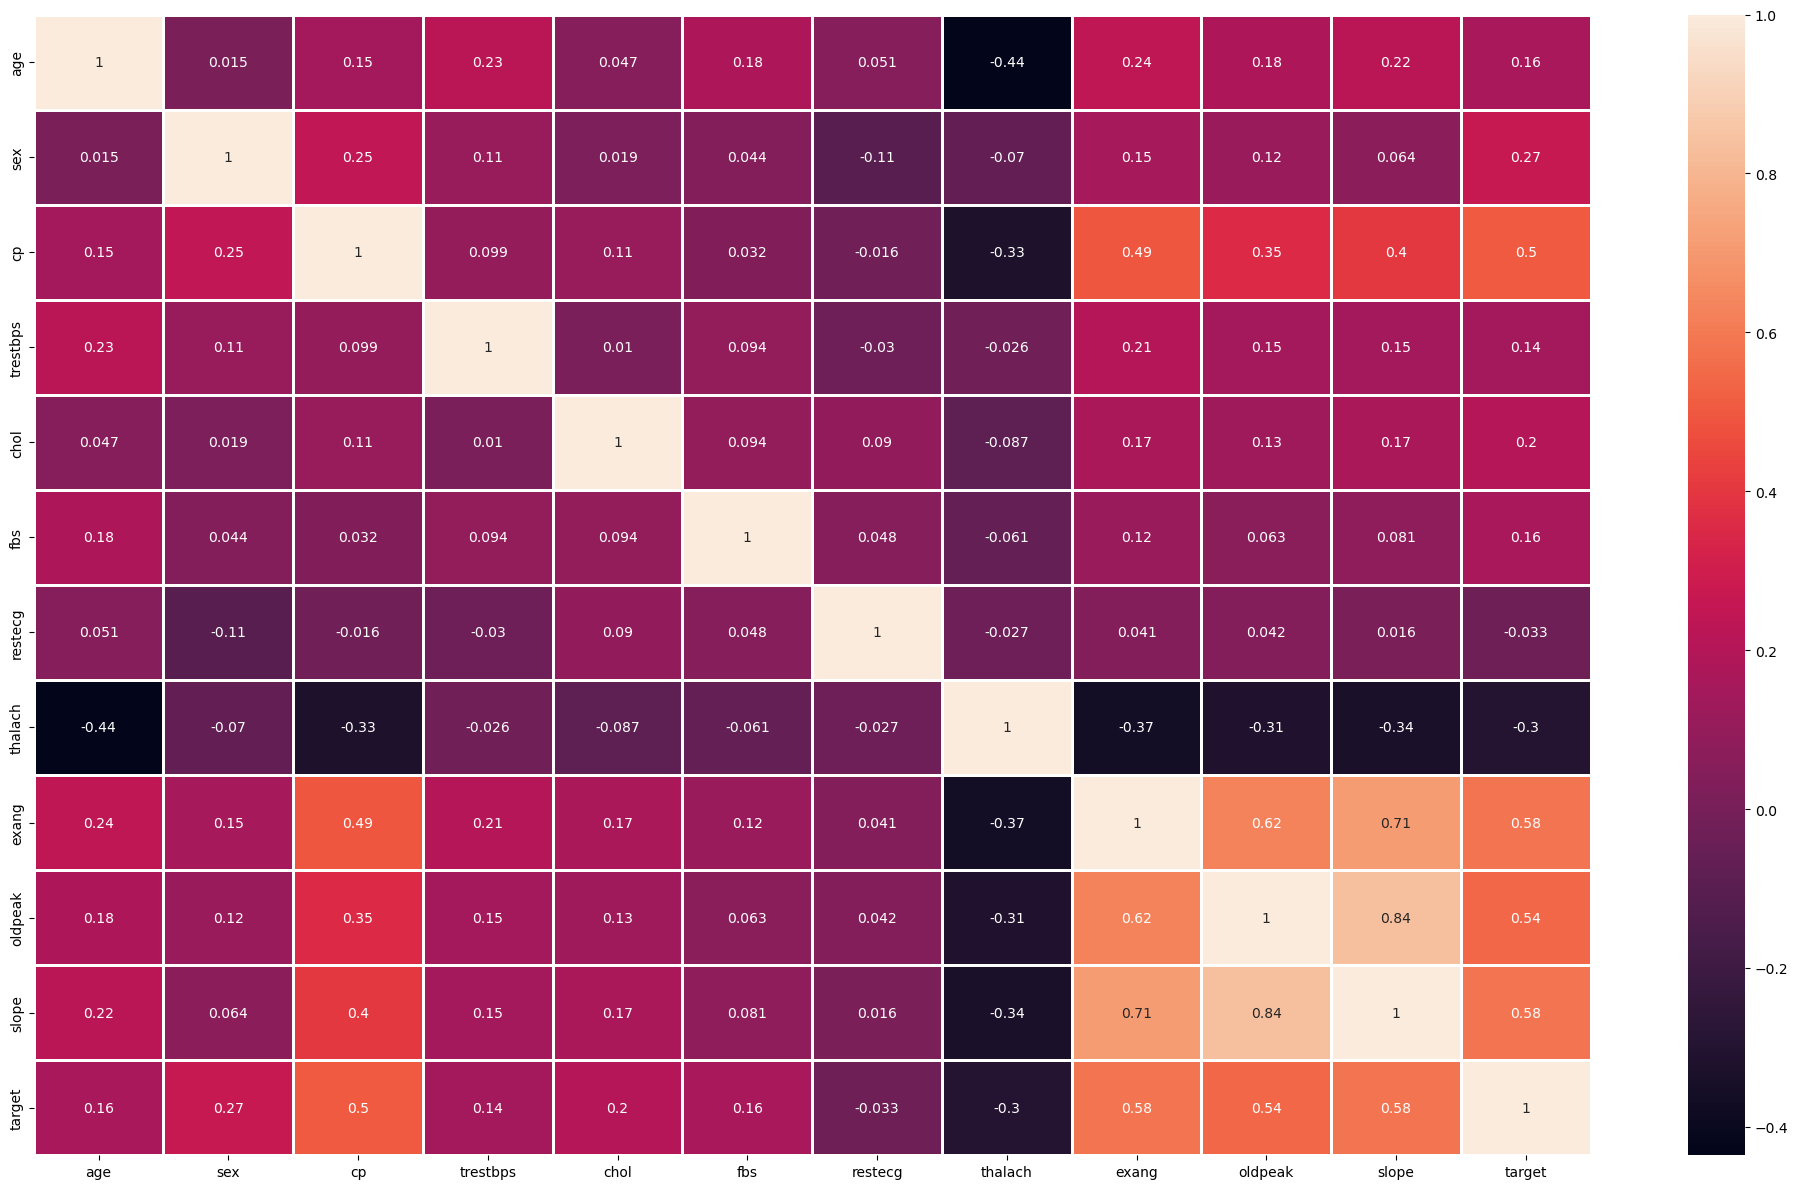

In [22]:
plt.figure(figsize=(20,12))
sns.heatmap(df_cleaned.corr(),annot=True,linewidth =2)
plt.tight_layout()

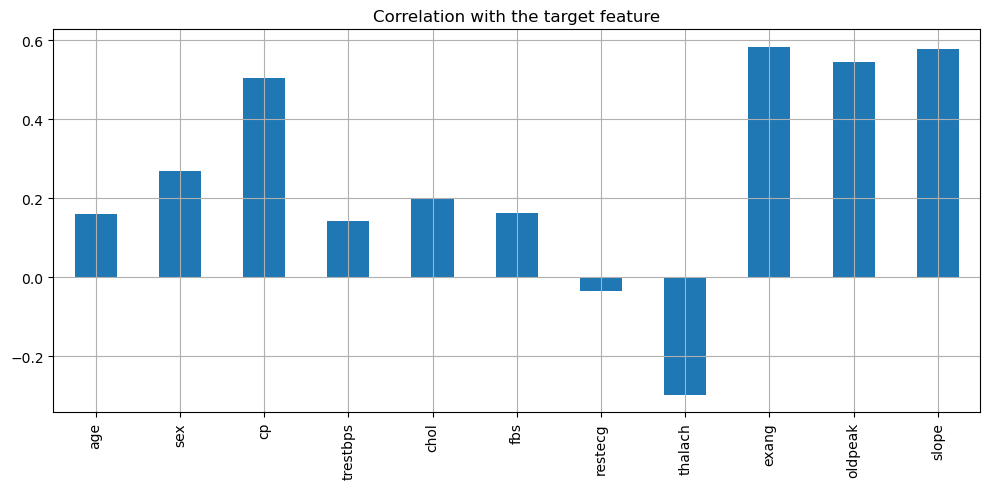

In [23]:
df_cleaned.drop('target', axis=1).corrwith(df_cleaned.target).plot(kind='bar', grid=True, figsize=(10, 5),
                                                   title="Correlation with the target feature")
plt.tight_layout()

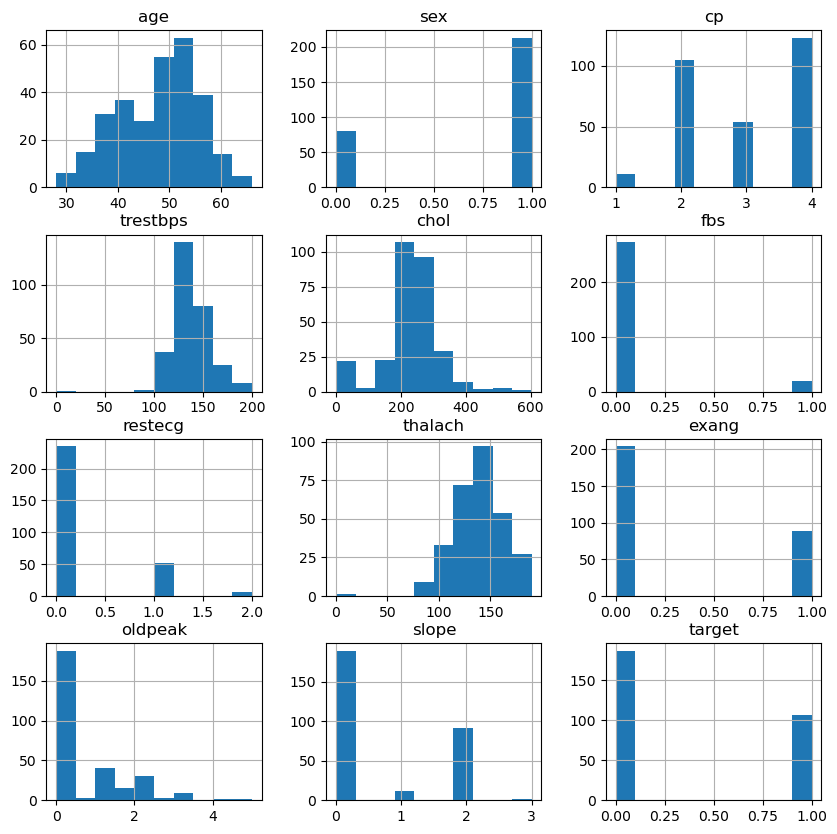

In [24]:
df_cleaned.hist(figsize=(10,10));

In [25]:
df_cleaned.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,target
count,293.000000,293.000000,293.000000,293.000000,293.000000,293.000000,293.000000,293.000000,293.000000,293.000000,293.000000,293.000000
mean,47.822526,0.726962,2.986348,132.208191,232.013652,0.068259,0.218430,138.583618,0.303754,0.588055,0.672355,0.361775
std,7.824875,0.446282,0.965049,19.209578,92.831228,0.252622,0.460868,24.919404,0.460665,0.909554,0.929991,0.481336
min,28.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,42.000000,0.000000,2.000000,120.000000,198.000000,0.000000,0.000000,122.000000,0.000000,0.000000,0.000000,0.000000
50%,49.000000,1.000000,3.000000,130.000000,237.000000,0.000000,0.000000,140.000000,0.000000,0.000000,0.000000,0.000000
75%,54.000000,1.000000,4.000000,140.000000,277.000000,0.000000,0.000000,155.000000,1.000000,1.000000,2.000000,1.000000
max,66.000000,1.000000,4.000000,200.000000,603.000000,1.000000,2.000000,190.000000,1.000000,5.000000,3.000000,1.000000


# ML MODELS

## Introduction
Introduction to model performance evaluation

#### Prediction | Actual Value | Designation
    1     |       1      |     TP
    1     |       0      |     FP
    0     |       1      |     FN
    0     |       0      |     TN

- **accuracy**: What percentage of the predictions are correct?
    - accuracy = (TP/TN) / N
- **precision**: What percentage of the predicted positive cases ("1") are really positive?
    - precision = TP / (TP+FP)
- **recall**: What percentage of the actually positive cases ("1") is recognized by the model?
    - recall = TP / (TP+FN)
- **f1-score**: Predictions should both have a high hit rate and be precise:
    - F1 = 2 * (precision * recall) / (precision + recall)

## Splitting and scaling the data

In [26]:
target = df_cleaned["target"]
features = df_cleaned.drop(["target"], axis = 1)

In [27]:
scaler = MinMaxScaler()
scaler.fit(features)

features_scaled = scaler.transform(features)

In [28]:
print("features == features_scaled: ", features.shape == features_scaled.shape)

features == features_scaled:  True


In [29]:
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(features_scaled, 
                                                                                target,
                                                                                test_size = 0.2, 
                                                                                random_state = 8888)

In [30]:
X_train, X_test, y_train, y_test = train_test_split(features,
                                                    target,
                                                    test_size = 0.2,
                                                    random_state = 8888)

In [31]:
print("Scaled Data")
print("Shape of X_train_scaled", X_train_scaled.shape)
print("Shape of X_test_scaled", X_test_scaled.shape)
print("Shape of y_train_scaled", y_train_scaled.shape)
print("Shape of y_test_scaled", y_test_scaled.shape)
print()

print("Standard Data")
print("Shape of X_train", X_train.shape)
print("Shape of X_test", X_test.shape)
print("Shape of y_train", y_train.shape)
print("Shape of y_test", y_test.shape)

Scaled Data
Shape of X_train_scaled (234, 11)
Shape of X_test_scaled (59, 11)
Shape of y_train_scaled (234,)
Shape of y_test_scaled (59,)

Standard Data
Shape of X_train (234, 11)
Shape of X_test (59, 11)
Shape of y_train (234,)
Shape of y_test (59,)


## Models

### Logistic Regression Model

In [32]:
classifier_logistic_regression = LogisticRegression()
classifier_logistic_regression.fit(X_train_scaled, y_train_scaled)

LogisticRegression()

In [33]:
y_pred_lr = classifier_logistic_regression.predict(X_test_scaled)
y_pred_lr

array([0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [34]:
print("accuracy:", round(accuracy_score(y_test_scaled, y_pred_lr), 2))
print("precision:", round(precision_score(y_test_scaled, y_pred_lr), 2))
print("recall:", round(recall_score(y_test_scaled, y_pred_lr), 2))
print("f1-score:", round(f1_score(y_test_scaled, y_pred_lr), 2))

accuracy: 0.8
precision: 0.71
recall: 0.63
f1-score: 0.67


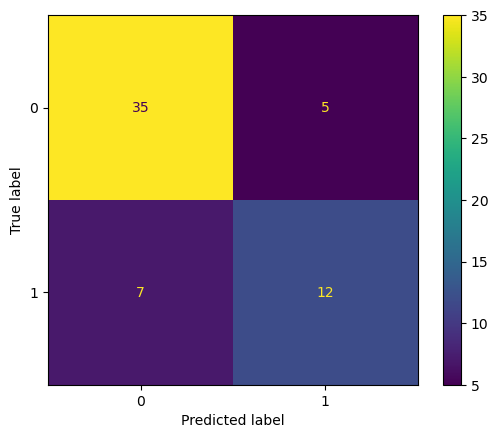

In [35]:
cm_lr = confusion_matrix(y_test_scaled, y_pred_lr)
disp_lr = ConfusionMatrixDisplay(confusion_matrix=cm_lr,
                               display_labels=classifier_logistic_regression.classes_)

disp_lr.plot()
plt.show()

In [36]:
print(classification_report(y_test_scaled, y_pred_lr))

              precision    recall  f1-score   support

           0       0.83      0.88      0.85        40
           1       0.71      0.63      0.67        19

    accuracy                           0.80        59
   macro avg       0.77      0.75      0.76        59
weighted avg       0.79      0.80      0.79        59



C:\Users\Matheus\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
5 fits failed out of a total of 25.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Matheus\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Matheus\anaconda3\Lib\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Matheus\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py", line 1246, in fit
    rais

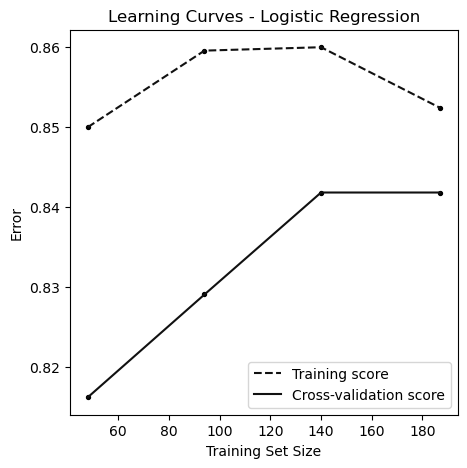

In [37]:
fig_lr = learning_curve_plot(classifier_logistic_regression, X_train_scaled, y_train_scaled, scoring = 'accuracy', plusTitle = "- Logistic Regression")
plt.show()

### Decision Tree

In [38]:
classifier_decision_tree = DecisionTreeClassifier()
classifier_decision_tree.fit(X_train, y_train)

DecisionTreeClassifier()

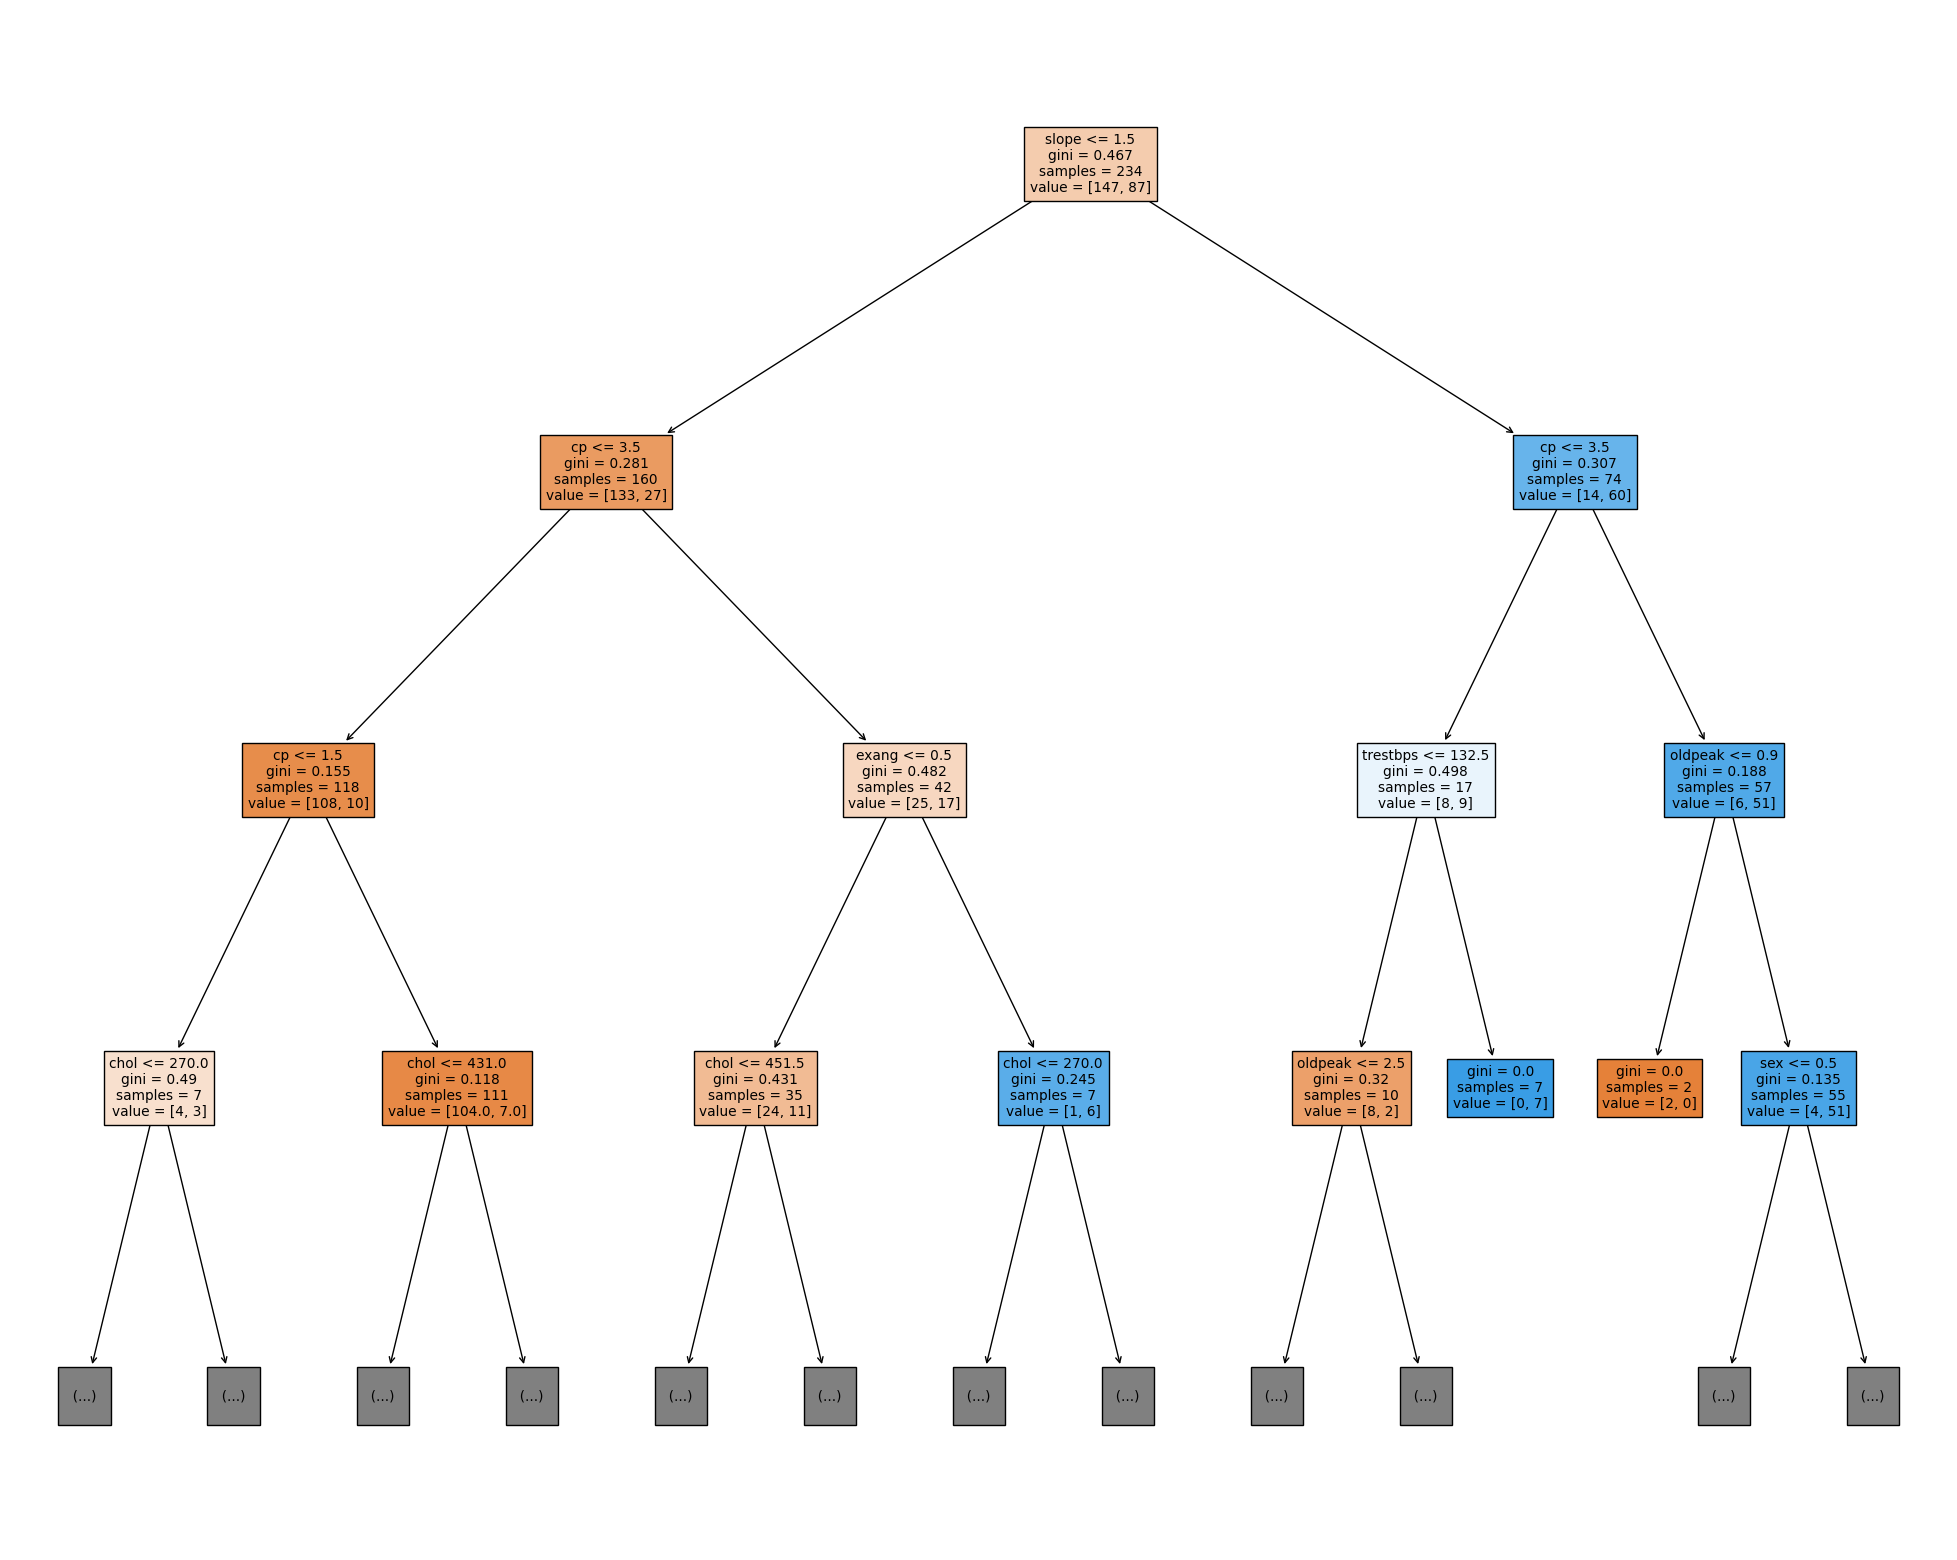

In [39]:
fig = plt.figure(figsize=(25 , 20))
_ = tree.plot_tree(classifier_decision_tree, 
                   feature_names = list(X_train.columns),  
                   max_depth = 3,
                   filled = True)

In [40]:
y_pred_dt = classifier_decision_tree.predict(X_test) 
y_pred_dt

array([0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1], dtype=int64)

In [41]:
print("accuracy:", round(accuracy_score(y_test, y_pred_dt), 2))
print("precision:", round(precision_score(y_test, y_pred_dt), 2))
print("recall:", round(recall_score(y_test, y_pred_dt), 2))
print("f1-score:", round(f1_score(y_test, y_pred_dt), 2))

accuracy: 0.73
precision: 0.57
recall: 0.68
f1-score: 0.62


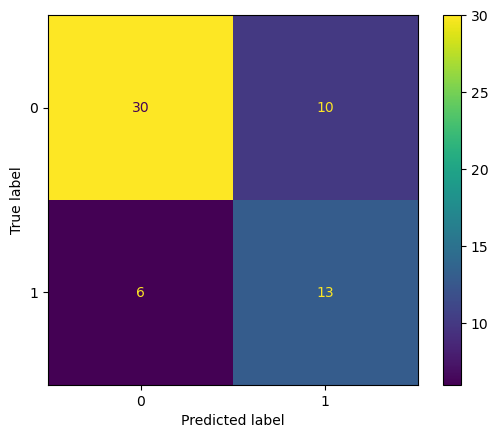

In [42]:
cm_dt = confusion_matrix(y_test, y_pred_dt)
disp_dt = ConfusionMatrixDisplay(confusion_matrix=cm_dt,
                               display_labels=classifier_logistic_regression.classes_)

disp_dt.plot()
plt.show()

In [43]:
print(classification_report(y_test, y_pred_dt))

              precision    recall  f1-score   support

           0       0.83      0.75      0.79        40
           1       0.57      0.68      0.62        19

    accuracy                           0.73        59
   macro avg       0.70      0.72      0.70        59
weighted avg       0.75      0.73      0.73        59



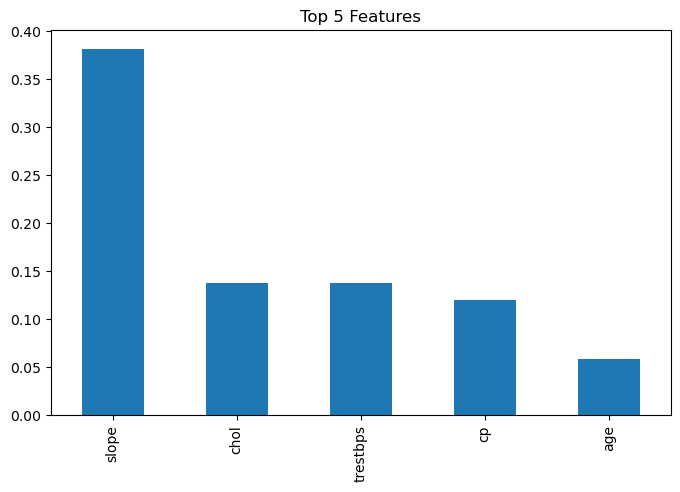

In [44]:
feature_importance_plot(classifier_decision_tree, X_train, n = 5)

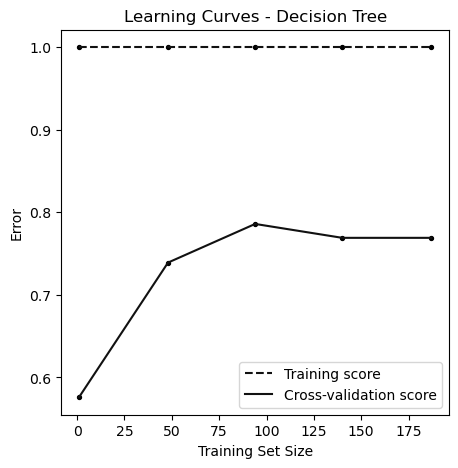

In [45]:
fig_dt = learning_curve_plot(classifier_decision_tree, X_train, y_train, scoring = 'accuracy', plusTitle = "- Decision Tree")
plt.show()

### Random Forest

In [46]:
classifier_random_forest = RandomForestClassifier()
classifier_random_forest.fit(X_train, y_train)

RandomForestClassifier()

In [47]:
y_pred_rf = classifier_random_forest.predict(X_test) 
y_pred_rf

array([0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], dtype=int64)

In [48]:
print("accuracy:", round(accuracy_score(y_test, y_pred_rf), 2))
print("precision:", round(precision_score(y_test, y_pred_rf), 2))
print("recall:", round(recall_score(y_test, y_pred_rf), 2))
print("f1-score:", round(f1_score(y_test, y_pred_rf), 2))

accuracy: 0.75
precision: 0.6
recall: 0.63
f1-score: 0.62


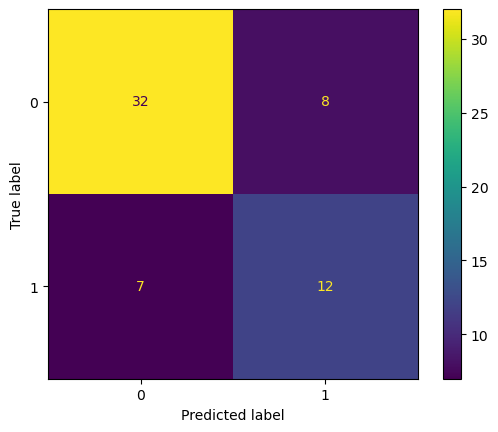

In [49]:
cm_rf = confusion_matrix(y_test, y_pred_rf)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf,
                               display_labels=classifier_logistic_regression.classes_)

disp_rf.plot()
plt.show()

In [50]:
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.82      0.80      0.81        40
           1       0.60      0.63      0.62        19

    accuracy                           0.75        59
   macro avg       0.71      0.72      0.71        59
weighted avg       0.75      0.75      0.75        59



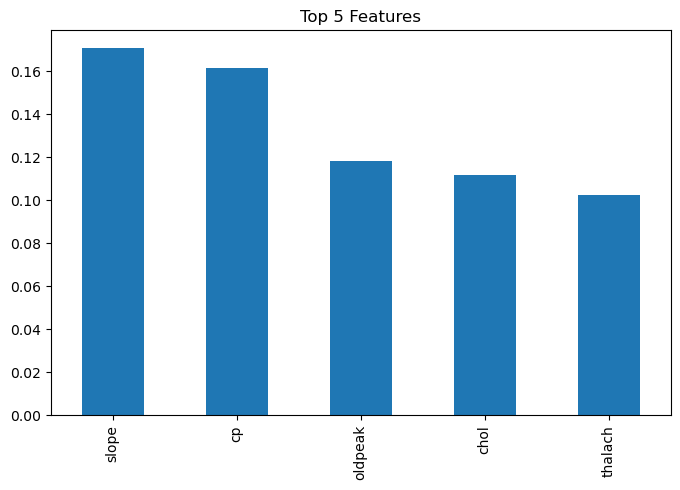

In [51]:
feature_importance_plot(classifier_random_forest, X_train, n = 5)

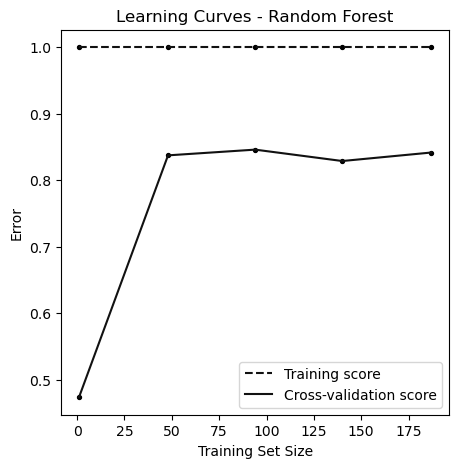

In [52]:
fig_rf = learning_curve_plot(classifier_random_forest, X_train, y_train, scoring = 'accuracy', plusTitle = "- Random Forest")
plt.show()

### XGBoost

In [53]:
classifier_xgboost = XGBClassifier()
classifier_xgboost.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [54]:
y_pred_xgb = classifier_xgboost.predict(X_test) 
y_pred_xgb

array([0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1])

In [55]:
print("accuracy:", round(accuracy_score(y_test, y_pred_xgb), 2))
print("precision:", round(precision_score(y_test, y_pred_xgb), 2))
print("recall:", round(recall_score(y_test, y_pred_xgb), 2))
print("f1-score:", round(f1_score(y_test, y_pred_xgb), 2))

accuracy: 0.8
precision: 0.65
recall: 0.79
f1-score: 0.71


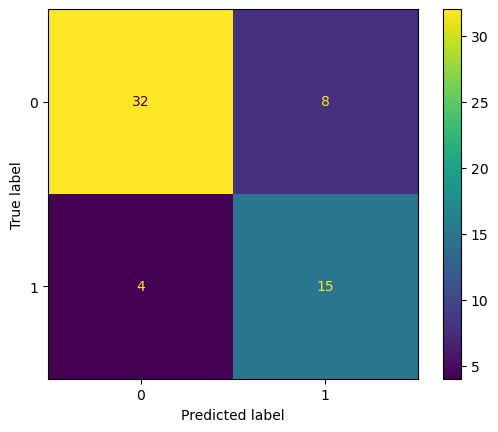

In [56]:
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
disp_xgb = ConfusionMatrixDisplay(confusion_matrix=cm_xgb,
                               display_labels=classifier_logistic_regression.classes_)

disp_xgb.plot()
plt.show()

In [57]:
print(classification_report(y_test, y_pred_xgb))

              precision    recall  f1-score   support

           0       0.89      0.80      0.84        40
           1       0.65      0.79      0.71        19

    accuracy                           0.80        59
   macro avg       0.77      0.79      0.78        59
weighted avg       0.81      0.80      0.80        59



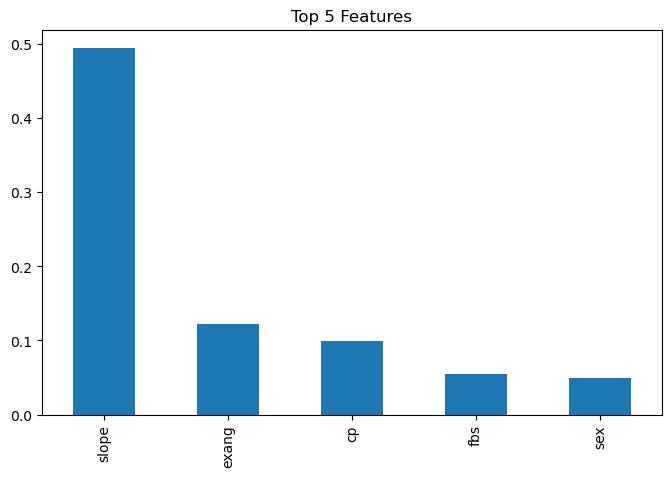

In [58]:
feature_importance_plot(classifier_xgboost, X_train, n = 5) 

C:\Users\Matheus\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
2 fits failed out of a total of 25.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Matheus\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Matheus\anaconda3\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "C:\Users\Matheus\anaconda3\Lib\site-packages\xgboost\sklearn.py", line 1491, in fit
    raise ValueError(
ValueError: Invalid classes inferred from unique v

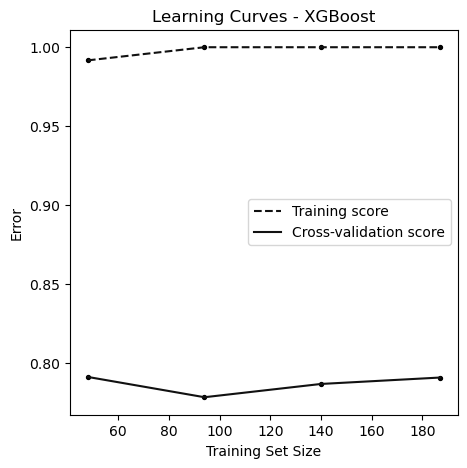

In [59]:
fig_xgb = learning_curve_plot(classifier_xgboost, X_train, y_train, scoring = 'accuracy', plusTitle = "- XGBoost")
plt.show()

# MODEL SELECTION

In [60]:
pd.DataFrame({"Model Name": ['Logistic Regression', 'Decision Tree', 'Random Forest', 'XGBoost'],
              "Model Variable Name": ['classifier_logistic_regression', 'classifier_decision_tree', 'classifier_random_forest', 'classifier_xgboost'],
              "Accuracy": [round(accuracy_score(y_test, y_pred_lr), 2), 
                           round(accuracy_score(y_test, y_pred_dt), 2),
                           round(accuracy_score(y_test, y_pred_rf), 2),
                           round(accuracy_score(y_test, y_pred_xgb), 2)],
              "Precision": [round(precision_score(y_test, y_pred_lr), 2), 
                           round(precision_score(y_test, y_pred_dt), 2),
                           round(precision_score(y_test, y_pred_rf), 2),
                           round(precision_score(y_test, y_pred_xgb), 2)],
              "Recall": [round(recall_score(y_test, y_pred_lr), 2), 
                        round(recall_score(y_test, y_pred_dt), 2),
                        round(recall_score(y_test, y_pred_rf), 2),
                        round(recall_score(y_test, y_pred_xgb), 2)],
              "F1-Score": [round(f1_score(y_test, y_pred_lr), 2), 
                           round(f1_score(y_test, y_pred_dt), 2),
                           round(f1_score(y_test, y_pred_rf), 2),
                           round(f1_score(y_test, y_pred_xgb), 2)],
             })

,Model Name,Model Variable Name,Accuracy,Precision,Recall,F1-Score
0,Logistic Regression,classifier_logistic_regression,0.80,0.71,0.63,0.67
1,Decision Tree,classifier_decision_tree,0.73,0.57,0.68,0.62
2,Random Forest,classifier_random_forest,0.75,0.60,0.63,0.62
3,XGBoost,classifier_xgboost,0.80,0.65,0.79,0.71


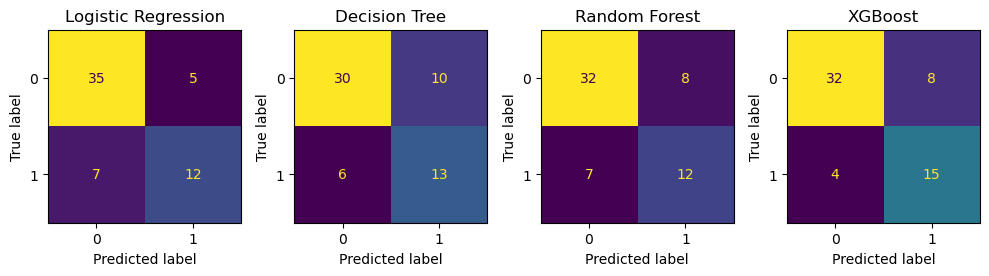

In [61]:
fig, axs = plt.subplots(1, 4, figsize=(10, 5))

disp_lr.plot(ax=axs[0], colorbar=False)
axs[0].set_title("Logistic Regression")

disp_dt.plot(ax=axs[1], colorbar=False)
axs[1].set_title("Decision Tree")

disp_rf.plot(ax=axs[2], colorbar=False)
axs[2].set_title("Random Forest")

disp_xgb.plot(ax=axs[3], colorbar=False)
axs[3].set_title("XGBoost")

plt.tight_layout()
plt.show()

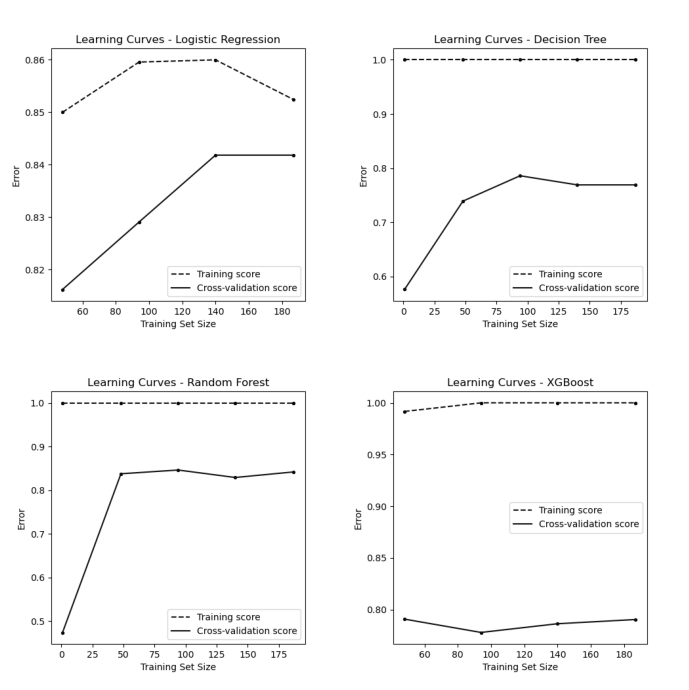

In [62]:
fig, axs = plt.subplots(2, 2, figsize=(7, 7))

fig_lr.canvas.draw()
axs[0][0].imshow(fig_lr.canvas.buffer_rgba())
axs[0][0].axis('off')

fig_dt.canvas.draw()
axs[0][1].imshow(fig_dt.canvas.buffer_rgba())
axs[0][1].axis('off')

fig_rf.canvas.draw()
axs[1][0].imshow(fig_rf.canvas.buffer_rgba())
axs[1][0].axis('off')

fig_xgb.canvas.draw()
axs[1][1].imshow(fig_xgb.canvas.buffer_rgba())
axs[1][1].axis('off')

plt.tight_layout()
plt.show()

In [63]:
# chosen_model = classifier_logistic_regression
# chosen_model = classifier_decision_tree
# chosen_model = classifier_random_forest
chosen_model = classifier_xgboost

joblib.dump(chosen_model, '../model/best_model.joblib')

['../model/best_model.joblib']

In [64]:
print('END')

END
